# Imports

In [74]:
import pandas as pd
from json_functions import create_df_big_output, create_example

players_list, df = create_df_big_output('very-big.json', mirror=True)

In [116]:
import numpy as np
import tensorflow as tf
import os

In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import tensorflow.keras.backend as K 

In [77]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [78]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile

# Check GPU

In [79]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Create dataset from json file

In [80]:
features, outputs = df["rosters vector"], df['rating vector']

features = pd.DataFrame(features.values.tolist(), index= df.index)
outputs = pd.DataFrame(outputs.values.tolist(), index= df.index)

print(np.shape(features))
print(np.shape(outputs))

(17488, 1068)
(17488, 1068)


In [81]:
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(features, outputs, test_size=0.1, random_state=42)

# I'm just going to use train_test_split again to create a validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

validation_ds = (X_val, y_val)

In [82]:
print(len(X_train))
print(len(X))

14165
15739


# Set a global batch size and steps per epoch

I need to set the global batch size for my custom loss function to work.

In [83]:
# I'll use steps per epoch instead of batch size because my custom loss function could be innacurate on a smaller batch at end of training set
GLOBAL_BATCH_SIZE = 329
STEPS_PER_EPOCH = len(X_train)//GLOBAL_BATCH_SIZE

# Create custom loss function

In [84]:
# create loss function that only takes into account values from the output dont have a true value of 0
class Filtered_MAE(tf.keras.losses.Loss):

    def call(self, y_true, y_pred):
        loss = my_loss(y_true, y_pred)
        loss_divided_by_batch = tf.divide(loss, GLOBAL_BATCH_SIZE)
        return loss_divided_by_batch

The sigmoid defined by my_step is very close to a step function, if x = 0, then it will return nearly 0, and if x is a reasonable rating value, even something as low as 0.4, it will return (pretty much) 1. I will plug in y_true to this and then multiply the result by the error so that error on predictions where where y_true = 0 becomes tiny but where y_true is an actual rating stays pretty much the same

In [85]:
def my_loss(y_true, y_pred):
    
    def my_step(x):
        return tf.divide(1.0, tf.add(1.0, tf.exp(tf.multiply(-1000.0, tf.subtract(x, 0.02)))))
    
    # we can hardcode denominator as 10 since we know that there will always be 10 relevent values
    # in this case I just multiply by 0.1 for simplicity  
    loss = tf.multiply(0.1, tf.reduce_sum(tf.multiply(my_step(y_true), tf.abs(tf.subtract(y_pred, y_true)))))
    loss_per_batch = tf.divide(loss, GLOBAL_BATCH_SIZE)
    return loss

    # return K.in_train_phase(0, loss)
    # return loss_per_batch

# Set up tensorboard

In [135]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Create Compile and fit fucntion

In [172]:
def compile_and_fit(model, 
                    name,
                    max_epochs=1000, 
                    initial_lr=0.001, 
                    es_patience=50,
                    verbose=0):

    # Reduce the learning rate as training goes on
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        initial_lr,
        decay_steps=STEPS_PER_EPOCH*0.1*max_epochs,
        decay_rate=1,
        staircase=False)
    
    # Add early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=es_patience, 
                                                      verbose=1)

    model.compile(loss=Filtered_MAE(),
                  optimizer=tf.keras.optimizers.Adam(lr_schedule))
    
    for output in model.outputs:
        output._uses_learning_phase = True

    model.summary()

    history = model.fit(X_train,
                        y_train, 
                        verbose=verbose, 
                        epochs=max_epochs,
                        # steps_per_epoch=STEPS_PER_EPOCH,
                        batch_size = GLOBAL_BATCH_SIZE,
                        validation_data=validation_ds,
                        validation_batch_size = GLOBAL_BATCH_SIZE,
                        # validation_steps=STEPS_PER_EPOCH//10,
                        callbacks=[early_stopping,
                                   tf.keras.callbacks.TensorBoard(logdir/name)])
    print("Evaluation on test set:")
    mae = model.evaluate(X_test, y_test,
                         verbose=1,
                         batch_size = GLOBAL_BATCH_SIZE)
    
    return history


# Train a few models with different Architectures

In [150]:
n_inputs, n_outputs = features.shape[1], outputs.shape[1]
n_inputs

1068

In [151]:
linear_perceptron_model = Sequential([
    Dense(n_outputs, input_dim=n_inputs, activation='linear')
])

In [152]:
histories = {}
histories['linear'] =  compile_and_fit(model=linear_perceptron_model,
                                       name='linear',
                                       initial_lr=0.005)


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 1068)              1141692   
Total params: 1,141,692
Trainable params: 1,141,692
Non-trainable params: 0
_________________________________________________________________
Epoch 00052: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 3ms/step - loss: 0.2705


In [153]:
tanh_perceptron_model = Sequential([
    Dense(n_outputs, input_dim=n_inputs, activation='tanh')
])

In [154]:
histories['tanh_peceptron'] = compile_and_fit(model=tanh_perceptron_model,
                                              name='tanh_peceptron',
                                              initial_lr=0.005)

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_84 (Dense)             (None, 1068)              1141692   
Total params: 1,141,692
Trainable params: 1,141,692
Non-trainable params: 0
_________________________________________________________________
Epoch 00063: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2524


In [155]:
medium_model = Sequential([
    Dense(1068, input_dim=n_inputs, activation='relu'),
    Dense(500, activation='relu'),
    Dense(n_outputs)
])
histories['medium_model'] = compile_and_fit(model=medium_model,
                                            name='medium_model',
                                            initial_lr=0.001)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_86 (Dense)             (None, 500)               534500    
_________________________________________________________________
dense_87 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00053: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2617


In [156]:
from tensorflow.keras import regularizers
medium_model_regularized = Sequential([
    Dense(1068, 
          input_dim=n_inputs,
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu'),
    Dense(500, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dense(n_outputs)
])
histories['medium_model_reg'] = compile_and_fit(model=medium_model_regularized,
                                                name='medium_model_reg', 
                                                max_epochs=1000, 
                                                initial_lr=0.001)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dense_89 (Dense)             (None, 500)               534500    
_________________________________________________________________
dense_90 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00142: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss: 0.2326


In [158]:
medium_model_dropout = Sequential([
    Dense(1068, input_dim=n_inputs, activation='relu'),
    Dropout(0.5),
    Dense(500, activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['medium_model_dropout'] = compile_and_fit(model=medium_model_dropout,
                                                    name='medium_model_dropout',
                                                    max_epochs=1000,
                                                    initial_lr=0.001)

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1068)              0         
_________________________________________________________________
dense_95 (Dense)             (None, 500)               534500    
_________________________________________________________________
dropout_35 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_96 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00053: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 4ms/step - loss

In [160]:
medium_model_dropout_regularized = Sequential([
    Dense(1068,
          input_dim=n_inputs,
          kernel_regularizer=regularizers.l2(0.001),
          activation='relu'),
    Dropout(0.5),
    Dense(500, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['medium_dropout_regularized'] = compile_and_fit(model=medium_model_dropout_regularized, 
                                                          name='medium_dropout_regularized',
                                                          max_epochs=1000, 
                                                          initial_lr=0.001)

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 1068)              1141692   
_________________________________________________________________
dropout_36 (Dropout)         (None, 1068)              0         
_________________________________________________________________
dense_98 (Dense)             (None, 500)               534500    
_________________________________________________________________
dropout_37 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 1068)              535068    
Total params: 2,211,260
Trainable params: 2,211,260
Non-trainable params: 0
_________________________________________________________________
Epoch 00195: early stopping
Evaluation on test set:
6/6 [==============================] - 0s 3ms/step - loss

Text(0.5, 0, 'Epochs')

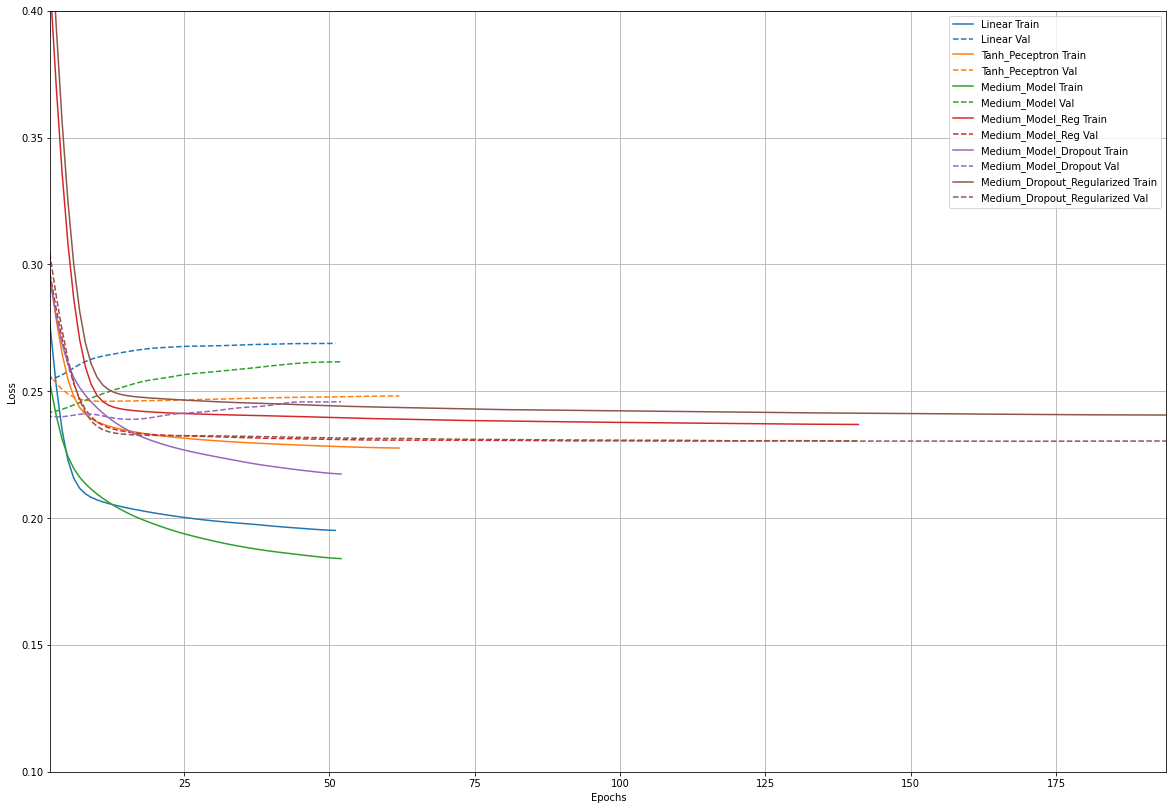

In [169]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)

plt.figure(figsize = (20,14))

plotter.plot(histories)
# a = plt.xscale('log')
plt.xlim([2, max(plt.xlim())])
plt.ylim([0.1, 0.4])
plt.xlabel("Epochs")

The medium model with dropout and regularization performed the best so far

## Train a particularly big model

This model has over 10k hidden units. 

In [173]:
huge_regularize_dropout_model = Sequential([
    Dense(2000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(4000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(8000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(4000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(2000, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(1068, input_dim=n_inputs, kernel_regularizer=regularizers.l2(0.001), activation='relu'),
    Dropout(0.5),
    Dense(n_outputs)
])
histories['huge_regularized_dropout'] = compile_and_fit(model=huge_regularize_dropout_model, 
                                                        name='huge_regularized_dropout',
                                                        max_epochs=1000, 
                                                        initial_lr=0.001,
                                                        verbose=1)

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 2000)              2138000   
_________________________________________________________________
dropout_50 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_118 (Dense)            (None, 4000)              8004000   
_________________________________________________________________
dropout_51 (Dropout)         (None, 4000)              0         
_________________________________________________________________
dense_119 (Dense)            (None, 8000)              32008000  
_________________________________________________________________
dropout_52 (Dropout)         (None, 8000)              0         
_________________________________________________________________
dense_120 (Dense)            (None, 4000)            

In [180]:
histories

{'huge_regularized_dropout': <tensorflow.python.keras.callbacks.History at 0x7f0c6590cad0>,
 'medium_dropout_regularized': <tensorflow.python.keras.callbacks.History at 0x7f0c3a457f10>,
 'medium_model_reg': <tensorflow.python.keras.callbacks.History at 0x7f0c570af150>,
 'tanh_peceptron': <tensorflow.python.keras.callbacks.History at 0x7f0c56326990>}

Text(0.5, 0, 'Epochs [Log Scale]')

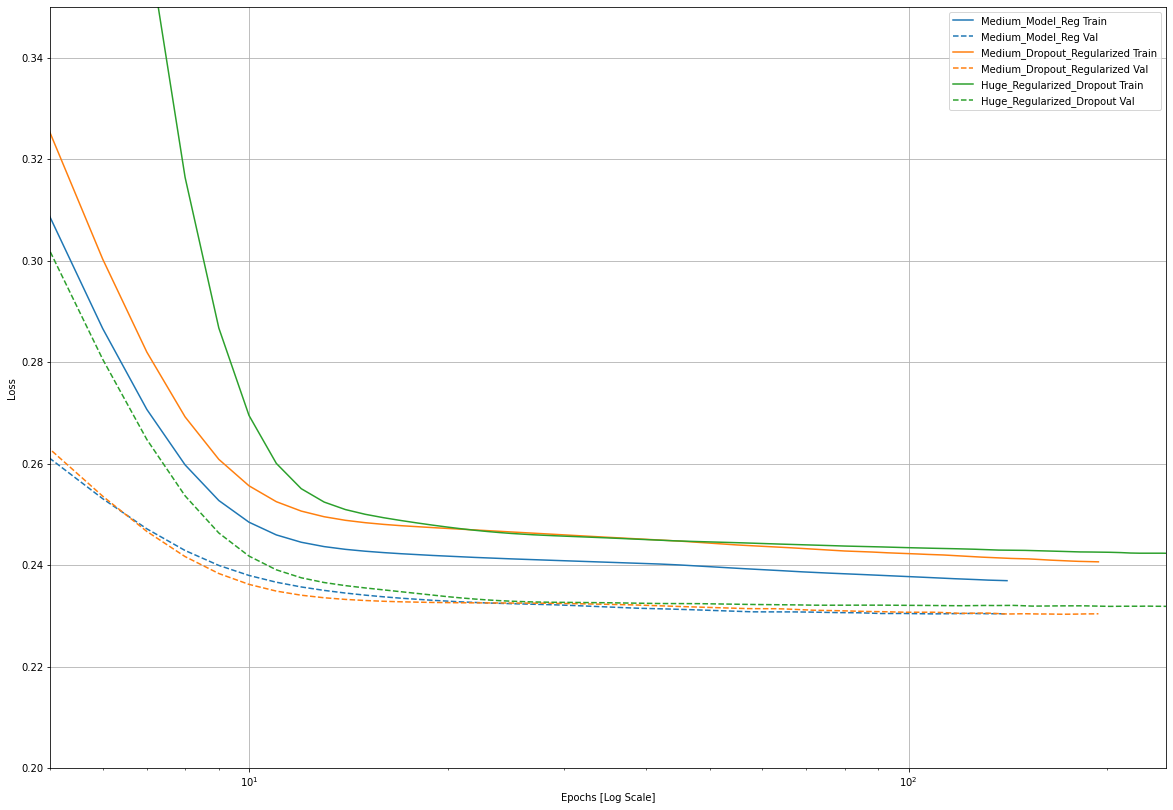

In [184]:
# histories_reduced = histories
# histories_reduced.pop('linear')
# histories_reduced.pop('medium_model')
# histories_reduced.pop('medium_model_dropout')
# histories_reduced.pop('tanh_peceptron')

plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)

plt.figure(figsize = (20,14))

plotter.plot(histories_reduced)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.2, 0.35])
plt.xlabel("Epochs [Log Scale]")

Despite being way bigger than the medium model the huge model perform no better. I think this implies that the problem is only solvable to this degree with the information I'm giving the model.

In [185]:
medium_model_regularized.save('med_l2reg.h5')